# Applied Data Visualization: Clustering

In the technical part of this lecture, we will introduce clustering, an **unsupervised** learning technique.

In [1]:
import numpy as np

from sklearn.datasets import make_blobs, make_moons, load_iris
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster import hierarchy 
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# sklearn is annoying about warnings, so we'll block them: 
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import matplotlib_inline
plt.rcParams['figure.figsize'] = (10, 6)
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#4daf4a","#ff7f00"])
color_array = ["#984ea3","#a65628","#ffff33","#4daf4a","#ff7f00", "#e41a1c", "#377eb8"]

## A first example

First, we'll create data using a function that generates [gaussian blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs).

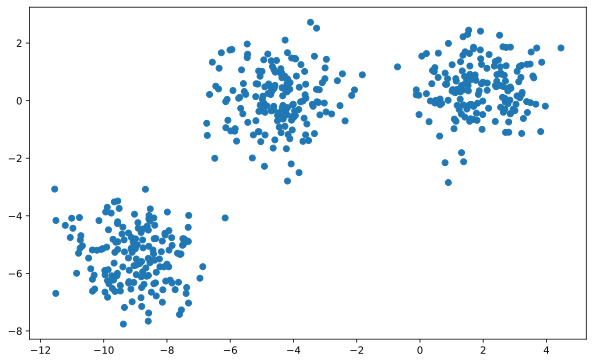

In [2]:
# make_blobs generates gaussian blobs, we create 3 blobs
n_samples = 500
random_state = 170

# X contains the data points as an array of tuples [[ 2.68626042e+00, -2.96125622e-01], [ 6.36611831e-01,  5.54466473e-02],... 
# y contains the labels (0, 1, 2)
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)

# plot data
plt.scatter(X[:, 0], X[:, 1],  marker="o")

Now we run the [scikit-learn KMeans implementation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) with function parameters 
* `n_clusters`: $k=3$ clusters
* `n_init`: we'll use only one initialization 
* `init`: we'll use random initialization 
* `max_iter`: we'll use only one iteration 

The clusters are plotted using color. 

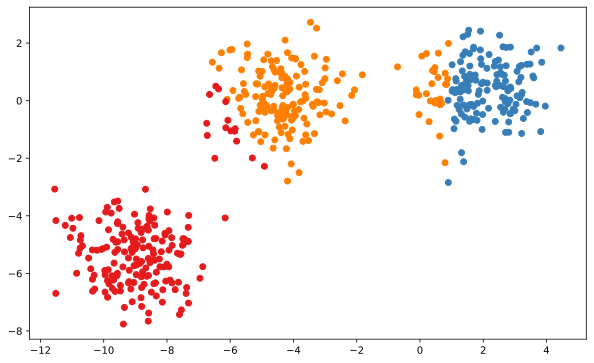

In [3]:
# y_pred contains the predicted labels
y_pred = KMeans(n_clusters=3, n_init=1, init='random', max_iter=1).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap);

Note that this is the dumbest possible version of k-means! This is essentially just random initialization + assign closest points. Try running this cell a couple of times so you see the effect of the initalization.

The results are highly dependent on the random initialization of the centroids. 

If we set the maximum number of iterations to 5, we already see some improvement.

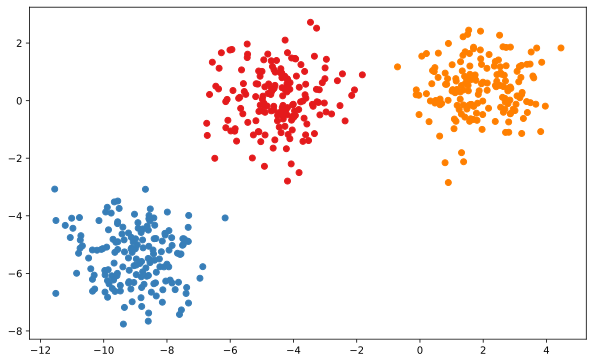

In [4]:
y_pred = KMeans(n_clusters=3, n_init=1, init='random', max_iter=5).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap);

**Let's review a few arguments:**

`n_init` is the Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of the total intra-cluster distance. Defaults to 10.

For the `init` parameter, there are two popular choices: 
 - `random` picks k random points for initial cluster seeds
 - `k-means++` (the default) uses the [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) [algorithm](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf) to "spread out" the initial seeds: the first cluster center is chosen uniformly at random from the data points that are being clustered, after which each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center.

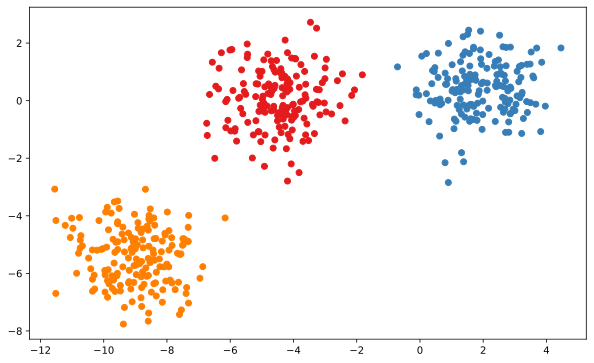

In [5]:
# For this simple dataset using k-means++ initalization and 10 runs of k-means,
# even a max_iter of 1 yields good results.
y_pred = KMeans(n_clusters=3, max_iter=1).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap);

## More complicated datasets

The total intra-cluster distance, however, makes the assumption that clusters are 
* convex
* isotropic (uniform in all orientations). 

Up to now, we've applied the algorithm only to nice, Gaussian blobs of equal size. Let's see what the algorithm does for point sets that 
* vary in size
* vary in variance
* are anisotropic 
* are non-convex.

### Varying Size

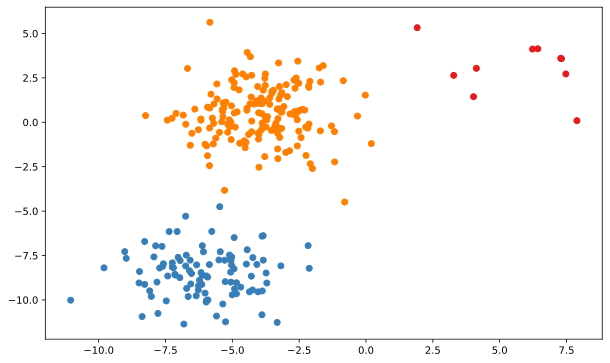

In [6]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=1.5, random_state=17)

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3).fit_predict(X_filtered)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred,  marker="o", cmap=cmap);

K-Means does fine for unevenly sized blobs in this case. 

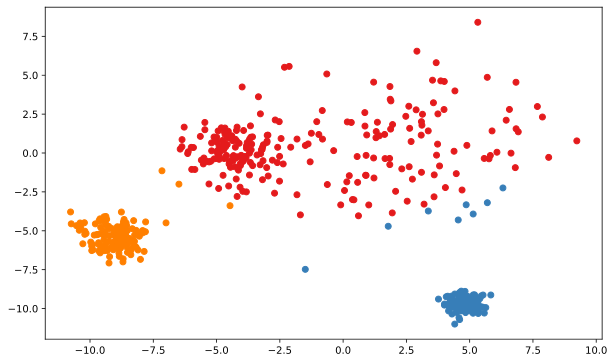

In [7]:
X, y = make_blobs(n_samples=n_samples, centers=4, cluster_std=[0.7, 1, 3, 0.4], random_state=random_state)

# Unevenly spread blobs
y_pred = KMeans(n_clusters=3).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap);

And it seems reasonable also for clusters that are spread out differently. 

### Anisotropic point clouds

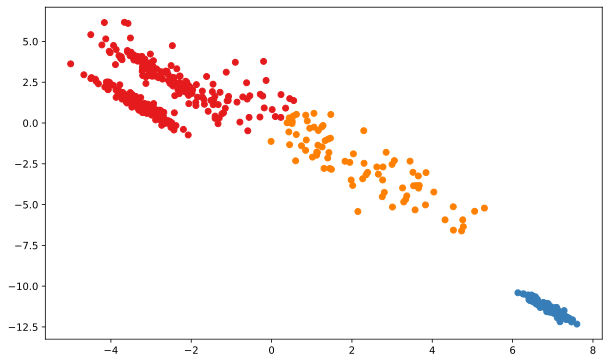

In [8]:
# Anisotropically distributed data
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

y_pred = KMeans(n_clusters=3).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred,  marker="o", cmap=cmap); 

Here we see a clear weakness of k-means, it doesn't work well for anisotropic point clouds. 

### Non-convex point clouds

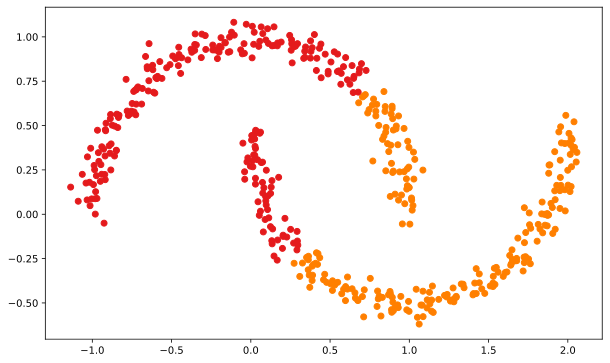

In [9]:
X_moons, y = make_moons(n_samples=n_samples, noise=.05)

y_pred = KMeans(n_clusters=2).fit_predict(X_moons)

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred,  marker="o", cmap=cmap);

The k-means method also doesn't work well for non-convex point clouds. 


## Choosing k in the k-means method
$k$-means is very sensitive to the choice of the parameter, $k$

Here, we under-estimate *k*.

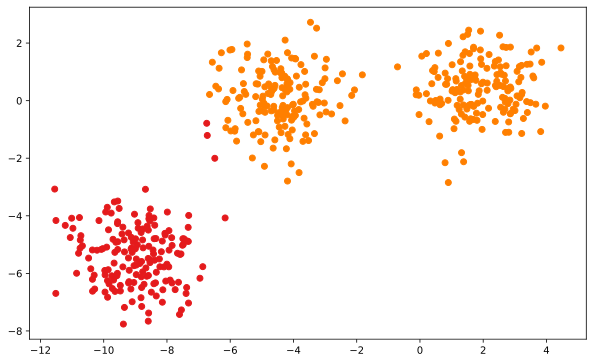

In [10]:
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)

y_pred = KMeans(n_clusters=2).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap);

Over-estimation is similarily problematic. 

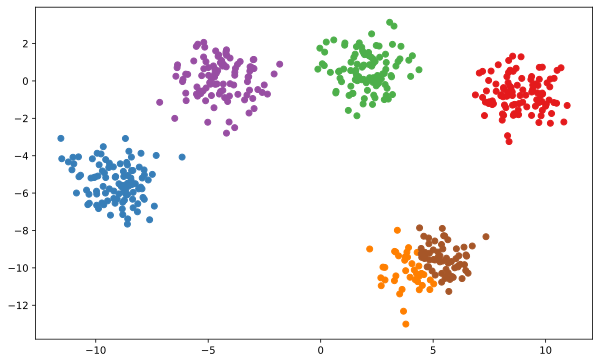

In [11]:
X, y = make_blobs(n_samples=n_samples, centers=5, random_state=random_state)
y_pred = KMeans(n_clusters=6).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap);

**How do you choose K?** Ideas:

In addition to visualizing the data and getting a sense of whether the clusters work, we can use two methods: 
+ Looking for at which $k$ the total intra-cluster distance tapers off. 

+ [Silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

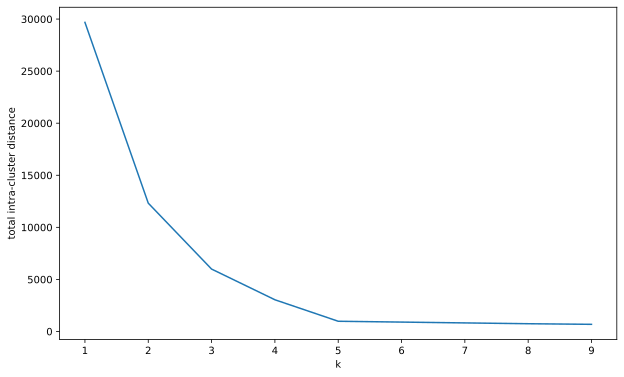

In [12]:

# clustering for k = 1 to k = 10
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(X)
    scores.append(-model.score(X))

plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

We can see that the total intra-cluster distance is large for $k = 1$ and decreases as we increase $k$, until $k=5$, after which it tapers of and gets only marginally smaller. This indicates that $k=5$ is a good choice.

Note: the scikit learn implementation returns negative values ("opposites of the k-means objective") as scores here.

## Silhouette Analysis
Another method for choosing the parameter $k$ in $k$-means is called a [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).


In a silhouette analysis, for each point in the dataset, we compare the distance between points in the same cluster and points in neighboring clusters, using the [`silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). 

The silhouette score is thus a measure of how similar an item is to its own cluster, and how different it is from other clusters. 

We compute it as follows. 

For each data element $i$ and cluster $\ell$, let $d(i,\ell)$ be the mean distance of $i$ and the points in cluster $\ell$. We interpret $d(i,\ell)$ as the disimilarity of $i$ with the items in cluster $\ell$: 
+ If $d(i,\ell)$ is small, then $i$ is very similar to the items in cluster $\ell$. 
+ If $d(i,\ell)$ is larger, then $i$ is very different from the items in cluster $\ell$.  

For each data element $i$, we define the *mean inter-cluster distance*
$$
a_i = d(i,\ell_i),
$$
where $\ell_i$ denotes the cluster that contains element $i$. Thus, $a_i$ measures how well element $i$ is assigned to its own cluster, with a small number being better. 

For each data element $i$, we define $b_i$ to be the *mean nearest-cluster distance*, that is, the smallest distance $d(i,\ell)$, where we only consider clusters $\ell$ for which $i$ is not a member:
$$
b_i = \min_{ \ell \colon i \notin \ell} d(i,\ell). 
$$

The *silhouette coefficient* for data element $i$ is then given by 
$$ 
s_i = \frac{b_i - a_i}{\max\{a_i, b_i\} }.
$$
The silhouette coefficient has a range of $[-1, 1]$ with 1 being good. **Why? What would cause a negative value?**

The *silhouette score* is the mean silhouette coefficient of all samples, 
$$
\frac{1}{n} \sum_{i=1}^n s_i.
$$


There is a nice plot, called a *silhouette plot*, which shows the silhouette coefficient for each sample. 

For n_clusters = 2 The silhouette_score is : 0.533649724736785


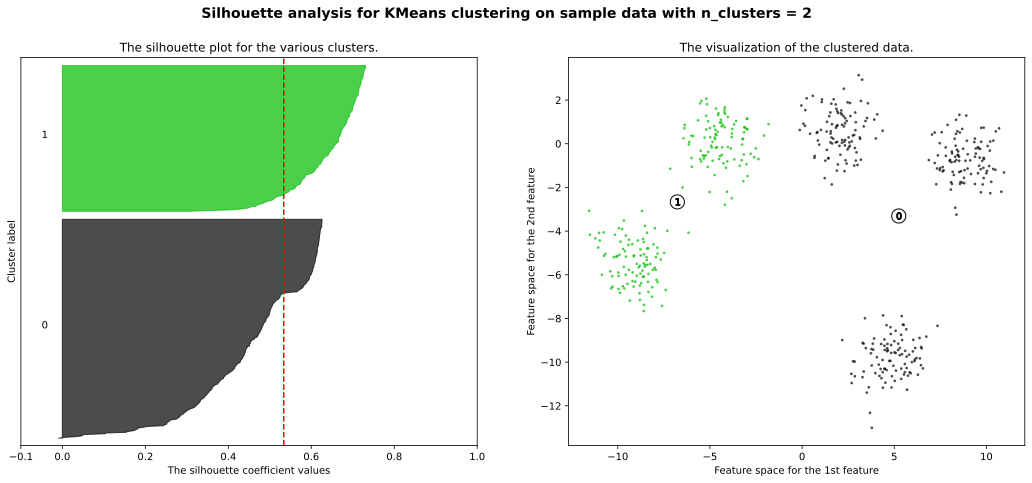

For n_clusters = 3 The silhouette_score is : 0.627286424150633


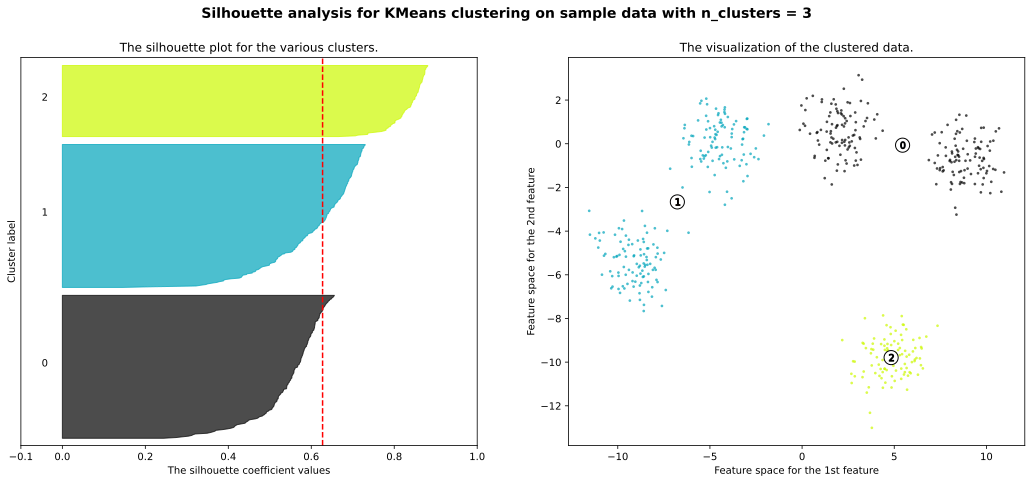

For n_clusters = 4 The silhouette_score is : 0.6485502042934127


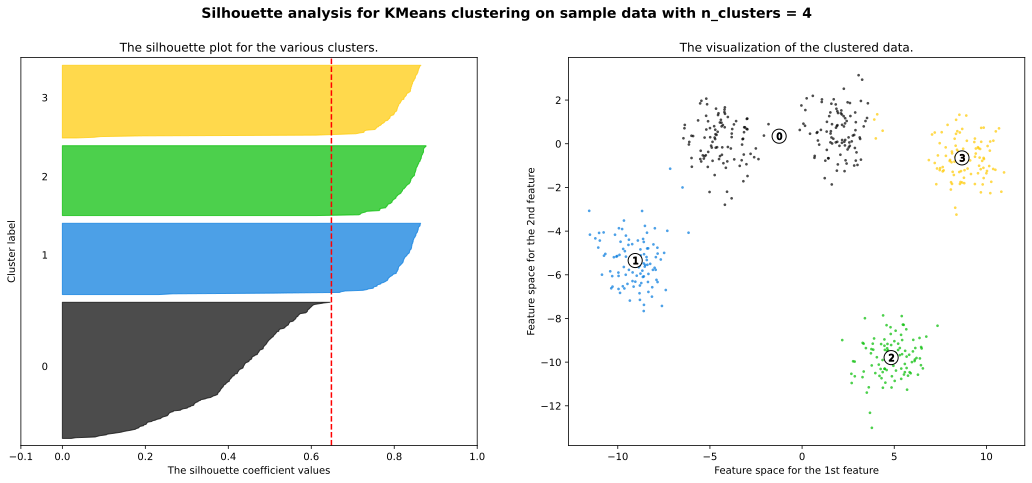

For n_clusters = 5 The silhouette_score is : 0.7454669692173231


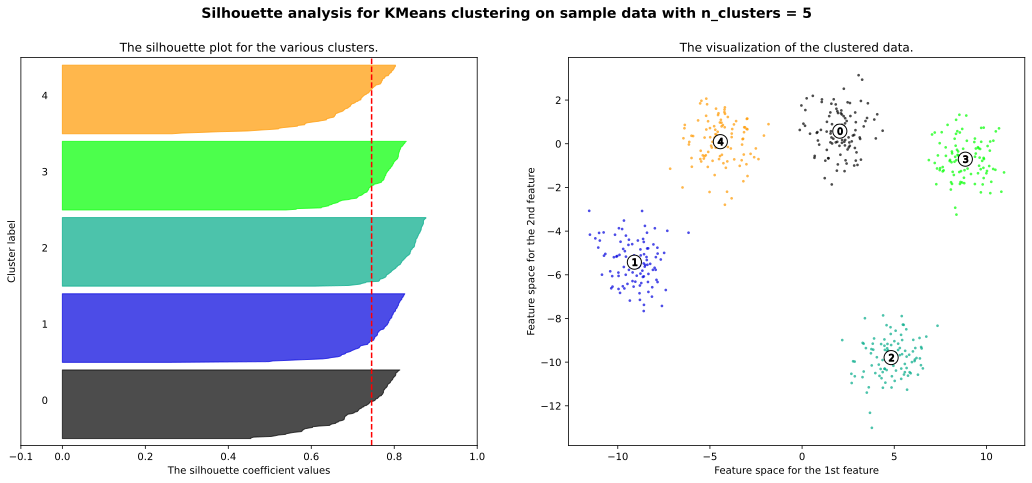

For n_clusters = 6 The silhouette_score is : 0.6685040780602695


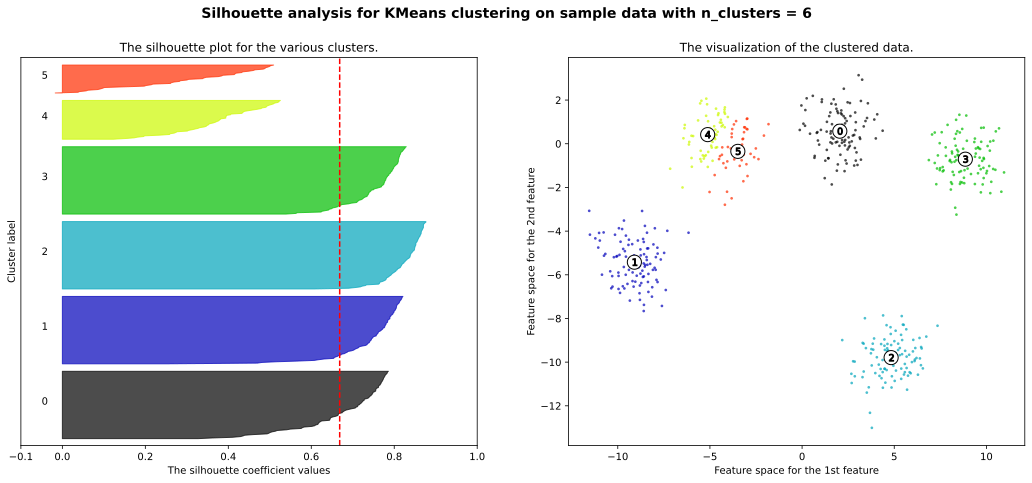

In [13]:
range_n_clusters = [2, 3, 4, 5, 6]


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette coefficient of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## Example: Iris dataset

We're going to look at how well k-means does on a higher dimensional example, the well-known Iris dataset. 

First, let's load the dataset and look at the first two dimensions. 

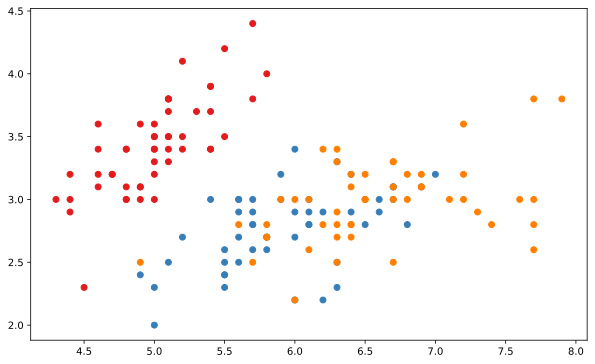

In [14]:
iris = load_iris()
X = iris.data
Y_iris_gt = iris.target

plt.scatter(X[:, 0], X[:, 1], c=Y_iris_gt, cmap=cmap);

Now let's run a clustering algorithm using all features (dimensions) and plot the results. 

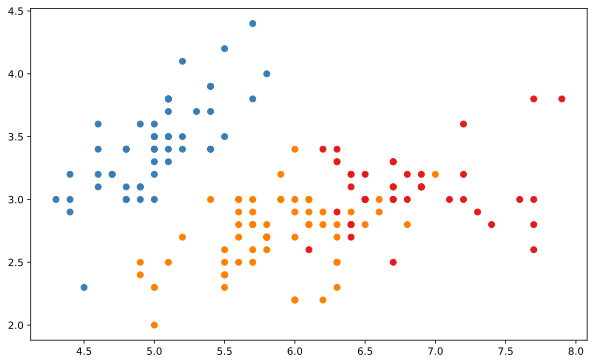

In [15]:
y_iris_pred = KMeans(n_clusters=3,n_init=100).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_iris_pred,  marker="o", cmap=cmap);

These clusters looks similar to the ground truth labels.

How do we evaluate the quality of the clusters? 

Just comparing the labels is difficult, since permutations of the labels shouldn't matter.

In [16]:
print(y_iris_pred)
print(Y_iris_gt)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


### Evaluating cluster quality with known ground-truth labels

1. [`homogeneity_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html): Homogeneity metric of a cluster labeling given a ground truth. A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
2. [`completeness_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html): A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
3. [`v_measure_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html): The V-measure is the harmonic mean between homogeneity and completeness:
$$
v = 2 * (homogeneity * completeness) / (homogeneity + completeness)
$$
4. [`homogeneity_completeness_v_measure`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_completeness_v_measure.html): Compute the homogeneity, completeness, and v-Measure scores at once.


In [17]:
print(metrics.homogeneity_score([0,0,1,1],[1,1,2,2]))
print(metrics.homogeneity_score([0,0,1,1],[0,0,0,1]))

1.0
0.31127812445913283


In [18]:
metrics.homogeneity_completeness_v_measure(Y_iris_gt,y_iris_pred)

(0.7514854021988338, 0.7649861514489815, 0.7581756800057784)

The homogeneity, completeness, and v-meausre scores are all approximately 76%. This is ok, but not great. 

# Hierarchical Clustering

We can use SciKit Learn's [agglomerative clustering implementation](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering). 

Here, we pass a number of clusters, because we can't see the hierarchy in this plot. Try changing the number of clusters to understand the behavior. 

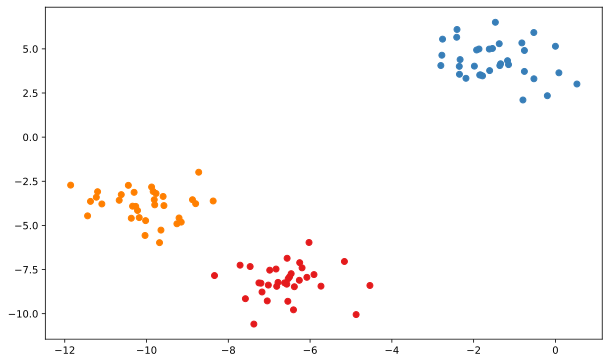

In [19]:

X, y = make_blobs(n_samples=100, centers=3, random_state=1)

# if we know there are 3 clusters
agg_cluster_model = AgglomerativeClustering(linkage='average', affinity='euclidean', n_clusters=3)
y_pred = agg_cluster_model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap); 

### Making a dendogram plot

A [dendogram plot](https://en.wikipedia.org/wiki/Dendrogram) can be used to decide on the number of clusters.

The `scipy.cluster.hierarchy` function [`linkage`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) returns an array of length $n-1$ that contains all cluster merging information. Each row has the format 
`[idx1, idx2, dist, sample_count]`.

The `scipy.cluster.hierarchy` function [`fcluster`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.fcluster.html) can then be used to extract the clusters from the linkage array and [`dendrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) to display the array.

In [20]:
Z = hierarchy.linkage(X, 'ward') # generate the linkage array
print(Z[:5])

[[3.30000000e+01 6.80000000e+01 2.17280603e-02 2.00000000e+00]
 [3.50000000e+01 3.90000000e+01 5.30292015e-02 2.00000000e+00]
 [1.80000000e+01 2.10000000e+01 7.84081035e-02 2.00000000e+00]
 [3.00000000e+01 9.20000000e+01 8.15250312e-02 2.00000000e+00]
 [5.40000000e+01 5.80000000e+01 8.51937937e-02 2.00000000e+00]]


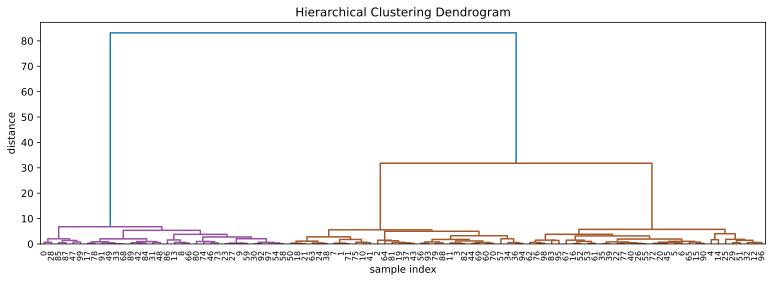

In [21]:
# dendrogram plot
plt.figure(figsize=(13, 4))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.set_link_color_palette(color_array)
hierarchy.dendrogram(Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8. # font size for the x axis labels
)
plt.show()

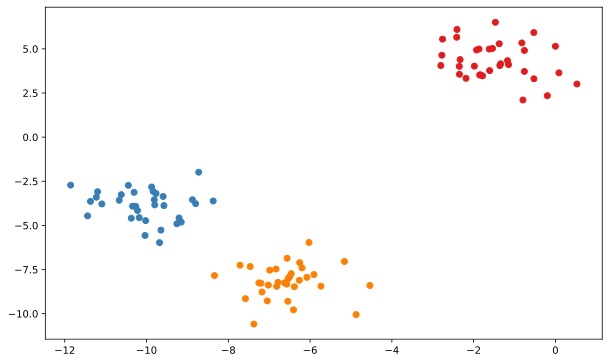

In [22]:
y_pred = hierarchy.fcluster(Z=Z, t=3, criterion='maxclust')
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap); 

## Example: two moons dataset

By default, agglomorative clustering doesn't take any connectivity into account. 

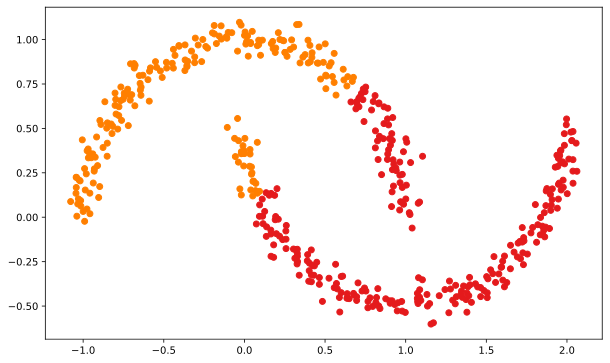

In [23]:
X_moons, y = make_moons(n_samples=500, noise=.05)

agg_cluster_model = AgglomerativeClustering(linkage="complete", affinity='euclidean', n_clusters=2)
y_pred = agg_cluster_model.fit_predict(X_moons)

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred,  marker="o", cmap=cmap);

### Adding connectivity constraints

Previously, we joined clusters based soley on distance. Here we introduce a [connectivity constraint](http://scikit-learn.org/stable/auto_examples/cluster/plot_ward_structured_vs_unstructured.html#sphx-glr-auto-examples-cluster-plot-ward-structured-vs-unstructured-py) based on k-Nearest Neighbors graph so that only adjacent clusters can be merged together. 

/Users/alex/anaconda3/envs/Oct23/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:575: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


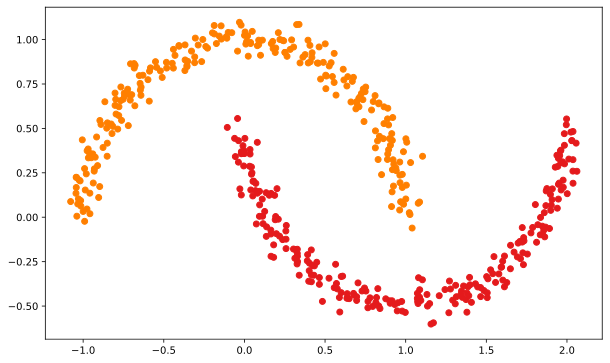

In [24]:
connectivity = kneighbors_graph(X_moons, n_neighbors=10, include_self=False)


agg_cluster_model = AgglomerativeClustering(linkage="complete", connectivity=connectivity, n_clusters=2,compute_full_tree=True)
y_pred = agg_cluster_model.fit_predict(X_moons)

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred,  marker="o", cmap=cmap);

## Example: IRIS Dataset

Recall the Iris dataset consists of 4 measurements for 150 different examples of irises. We know that there are $k=3$  species of irises in the dataset. Without using the labels, let's try to find them. Note: this is a harder problem than classification since we're not using the (known) labels! 

In [25]:
# load dataset 
iris = load_iris()

X_iris = iris.data
y_iris = iris.target

0.7700836616487869

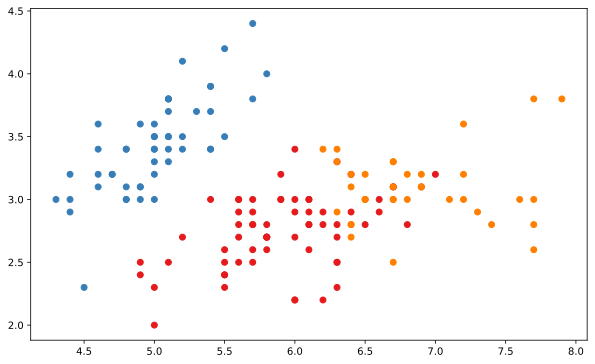

In [26]:
agg_cluster_model = AgglomerativeClustering(linkage="ward", affinity='euclidean', n_clusters=3)
y_pred = agg_cluster_model.fit_predict(X_iris)

plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_pred,  marker="o", cmap=cmap);
metrics.v_measure_score(labels_true=y_iris, labels_pred=y_pred)

Here's the plot with the ground truth labels: 

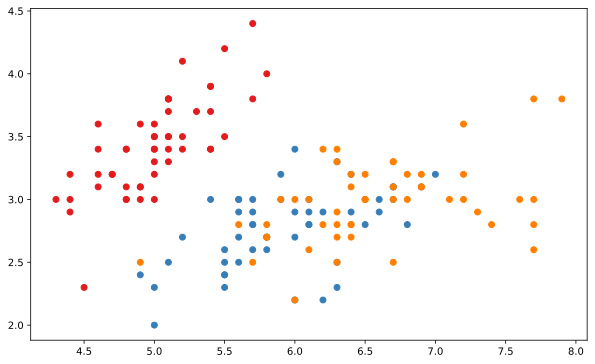

In [27]:
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris,  marker="o", cmap=cmap);

Remember that we're plotting only two dimensions of the dataset here, so it's tricky to see whether the clustering works well. 

A useful method to visuliaze a high-dimensional dataset are **cluster heatmaps**. Cluster heatmaps combine the dendrogram with a heat map, so you can judge the values of each dimension in a cluster. 

[Seaborn](https://seaborn.pydata.org/generated/seaborn.clustermap.html) provides a nice ready made cluster heatmap which we've already seen. This calles the scikit learn clustering algorithms behind the scenes. 

{'setosa': '#984ea3', 'versicolor': '#a65628', 'virginica': '#ffff33'}


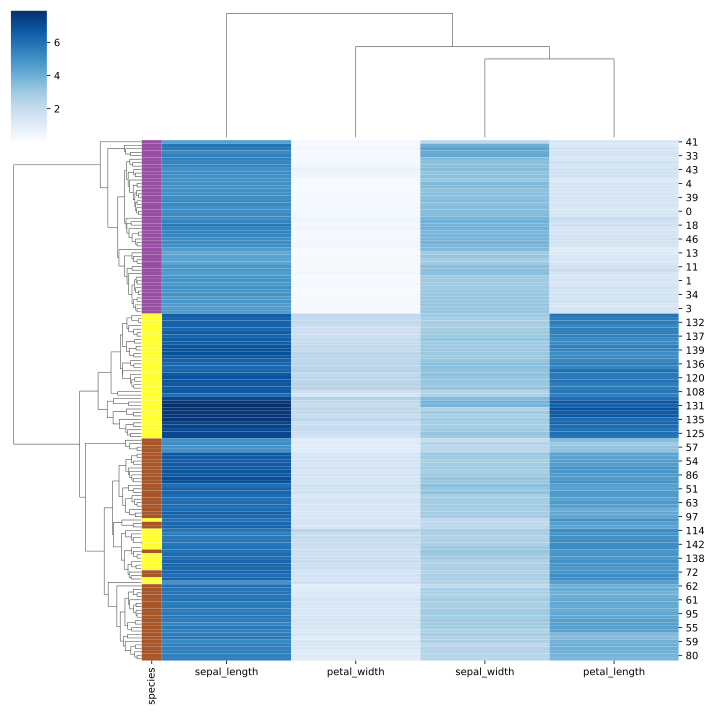

In [28]:
import seaborn as sns
iris = sns.load_dataset("iris")
species = iris.pop("species")

# the color for the labels
lut = dict(zip(species.unique(), color_array))
print(lut)
row_colors = species.map(lut)

# for method, try "single", "average", "ward"
# for method try "correlation", "euclidean", "cityblock"
g = sns.clustermap(iris, method="average", metric="euclidean", row_colors=row_colors, cmap="Blues")

### Evaluating the clusters

We can use the homogeneity/completeness/v-measure scores to evaluate our clusters. Here we'll try a couple of different configurations. 


In [29]:
homogeneity_completeness_v_measure(labels_true = y_iris, labels_pred = y_pred)

(0.7608008469718723, 0.7795958005591144, 0.7700836616487869)

We can now look at these scores for a couple of different parameters: 

In [30]:
models = [AgglomerativeClustering(linkage="ward", affinity='euclidean', n_clusters=3), 
         AgglomerativeClustering(linkage="average", affinity='euclidean', n_clusters=3), 
         AgglomerativeClustering(linkage="complete", affinity='euclidean', n_clusters=3), 
         AgglomerativeClustering(linkage="average", affinity='manhattan', n_clusters=3),
         AgglomerativeClustering(linkage="complete", affinity='manhattan', n_clusters=3),
         KMeans(n_clusters=3)]
h = np.zeros([len(models),3])
for i,m in enumerate(models):
    y_pred = m.fit_predict(X_iris)
    h[i,:] = homogeneity_completeness_v_measure(labels_true = y_iris, labels_pred = y_pred)
    print(h[i,:])

print('The winner is model #' + str(np.argmax(h[:,2]) + 1)
      + ' with V-Measure ' + str(np.max(h[:,2])))
print('Method details:')
print(models[np.argmax(h[:,0])])


[0.76080085 0.7795958  0.77008366]
[0.79598162 0.81564569 0.80569369]
[0.70011544 0.74543828 0.72206635]
[0.76959557 0.78590169 0.77766316]
[0.77817687 0.80358854 0.79067858]
[0.7514854  0.76498615 0.75817568]
The winner is model #2 with V-Measure 0.805693691215336
Method details:
AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=3)


We conclude that the average clustering method with the euclidean distance is the best match for this dataset. 

## DBScan

Density-based spatial clustering of applications with noise (DBSCAN) is an algorithm that is based on the premise that clusters are dense clouds of points, and that points that are in the same cluster should be close to each other. 

We need to choose two parameters: 
 * $\epsilon$, a measure for distance between two points, and 
 * *minPoints*, a measure for the minimum number of points in a cluster.

Scikit-learn also has a [DBSCAN implemetation](https://scikit-learn.org/stable/modules/clustering.html#dbscan). Note the outliers shown in the examples below. 





Estimated number of clusters: 5
Estimated number of noise points: 3
Homogeneity: 0.951
Completeness: 0.826
V-measure: 0.884


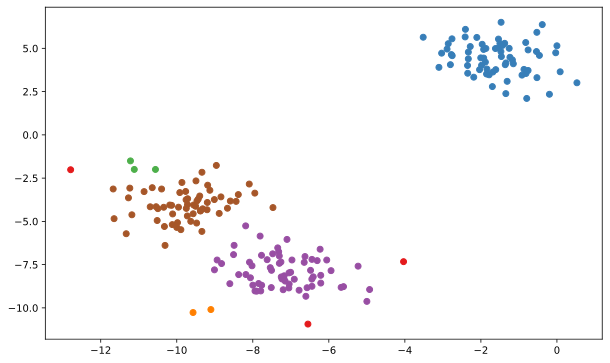

In [31]:
from sklearn.cluster import DBSCAN

X, y = make_blobs(n_samples=200, centers=3, random_state=1)

# try changeing eps and min_samples
db_model = DBSCAN(eps=1.0, min_samples=2)
db_model.fit(X)
y_pred = db_model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap); 

labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))

DBSCAN works well for uneven sized clusters:

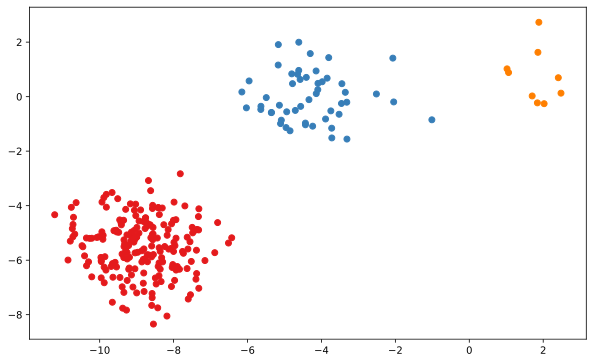

In [32]:
X, y = make_blobs(n_samples=1000, centers=3, random_state=170)

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:200], X[y == 1][:50], X[y == 2][:10]))


# try changeing eps and min_samples
db_model = DBSCAN(eps=1.5, min_samples=5)
db_model.fit(X_filtered)
y_pred = db_model.fit_predict(X_filtered)

plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred,  marker="o", cmap=cmap); 

It also works well for non-convex shapes, no extra tricks required.

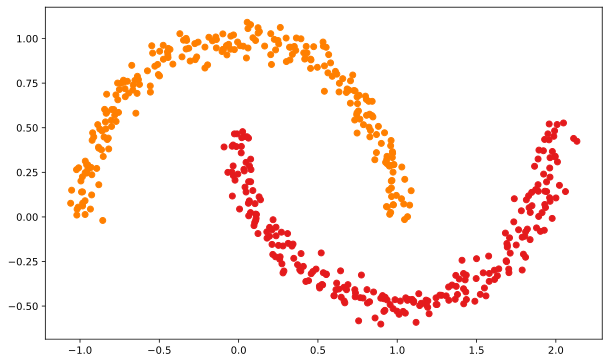

In [33]:
X_moons, y = make_moons(n_samples=500, noise=.05)

# try changeing eps and min_samples
db_model = DBSCAN(eps=0.2, min_samples=5)
db_model.fit(X_moons)
y_pred = db_model.fit_predict(X_moons)

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred,  marker="o", cmap=cmap); 

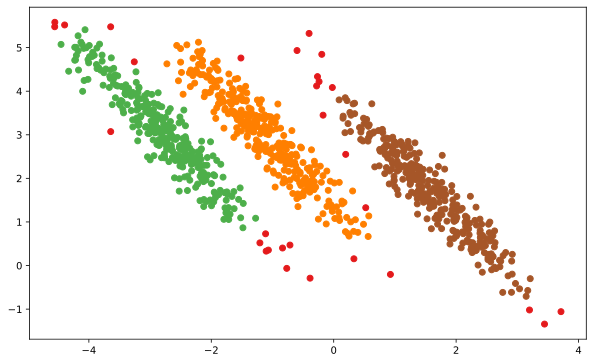

In [34]:
X, y = make_blobs(n_samples=1000, centers=3, random_state=3)

# Anisotropically distributed data
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

# try changeing eps and min_samples
db_model = DBSCAN(eps=0.30, min_samples=5)
db_model.fit(X_aniso)
y_pred = db_model.fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred,  marker="o", cmap=cmap); 

For the Iris dataset, it's hard for DBSCAN to tease apart the two correlated species. 

0.6124353984410543

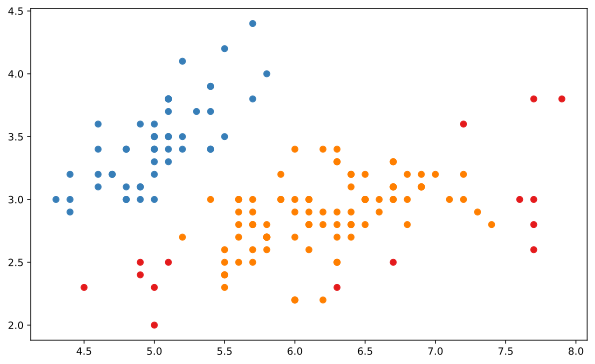

In [35]:
dbscan_cluster_model = DBSCAN(eps=0.55, min_samples=8)
y_pred = dbscan_cluster_model.fit_predict(X_iris)

plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_pred,  marker="o", cmap=cmap);
metrics.v_measure_score(labels_true=y_iris, labels_pred=y_pred)

DBScan doesn't work with clusters of unequal density. 

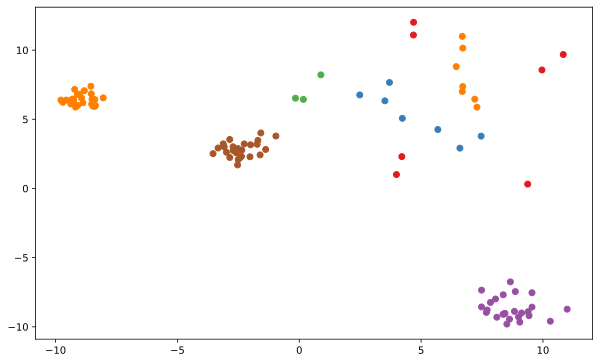

In [36]:
X, y = make_blobs(n_samples=100, centers=4, cluster_std=[0.7, 1, 3, 0.4], random_state=112)

# Unevenly spread blobs
y_pred = DBSCAN(eps=2, min_samples=3).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap);

Pros of DBSCAN: 

* Works for non-gaussian shapes. 
* Explicitly deals with outliers.
* We don't have to specify the nubmer of clusters. 

Cons: 

* Sensitve to parameters.
* Cannot cluster datasets with differences in densities between clusters – we have only one epsilon.